# Predicting error rates: per-location

We have distinct but related sets of questions about error rates.
1. What properties of subjects cause them to make more/fewer errors?
2. What properties of positions cause subjects to make more/fewer errors?
3. What properties of a particular piece in a positionc cause subjects to make more/fewer errors?

This notebook covers analyses for (2) and (3) above.

## Notebook setup

In [1]:
# Standard libraries
import os
import sys

# Scientific libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols

# Internal libraries
sys.path.append('../../src')

# import lib.reconstruction.errors as errs
from lib.reconstruction.errors import get_errors_per_location
from lib.reconstruction.neighbors import FilterByOccupied
from lib.reconstruction.neighbors import get_adjacency, get_adjacency_per_location

In [2]:
# Notebook configuration
pd.set_option('display.max_columns', 40)

sns.set_style('white')
sns.set_context('paper')

colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)

%matplotlib inline

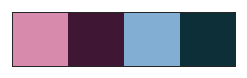

In [3]:
# View color palette
sns.palplot(colors)

## Load data

In [4]:
tidy = pd.read_csv('../../etc/reconstruction/tidy_data.csv', index_col=0)

tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)

vals = ['Black Position', 'White Position', 
        'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', 
                             values=vals, 
                             aggfunc=lambda x: x.unique()[0])[vals]

## Neighbors

In both working memory and chess literature, "chunking" of a visual object is an important concept. In visual working memory, chunks tend to be spatial groupings of stimuli. In chess literature, chunks can be sparse spatially but cohere instead according to game-relevant function (eg, a "pin" can be executed with a few pieces that are far from each other). In an MNK game as constrained as (4, 9, 4), these probably overlap - that is, even game-functional chunks are sptaially dense and probably overlap with working-memory chunks. 

**In this respect, MNK may not actually be as useful a game as chess for measuring working memory behavior against expertise, as the relevant visual chunks may not change much as expertise increases.**

There are a number of potential approaches to measuring chunk presence or the "chunkiness" of a board or positon. We begin with a very simple measure. For each location on the board, there are a discrete number of adjacent locations. We can measure the "neighborhood size" of a location as the fraction of adjacent locations that contain a piece[1]. Then, we can measure the "chunkiness" of a game position as the average neighborhood size of all locations.

We can further qualify these measures. First, we can choose to measure only occupied locations, rather than all locations. We might expect Type I errors, which occur only at unoccupied locations, to be more common when there are more neighbors around an unoccupied location. We might expect Type II errors, which occur only at occupied locations, to be more common when there are fewer neighbors around an occupied location. 

Second, we can distinguish between same-colored neighbors and opposite-colored neighbors. We might expect Type III errors, which occur only at occupied locations, to be more common when the number of opposite-colored neighbors is greater than the number of same-colored neighbors.

---

One potential confound we need to address is that performance differences may not derive from (visual) working memory limitations, but rather from subjects optimizing an alternative utility function that involves more than maximizing the number of correct responses. For example, they may be trying to finish the experiment more quickly. Call this the "laziness" hypothesis. If so, subjects may ignore pieces that fall far from clusters or the center of the board because it is time consuming and effortful to move the mouse to those locations.


---

[1] Fraction of occupied neighbors is a more appropriate measure than total occupied neighbors because of edge effects - locations at the edge of the board have fewer potential neighbors

### Data preprocessing

In [5]:
# Compute the adjacency of each location

adjacencies = board_set.apply(get_adjacency_per_location, axis=1)

adjacency_column_names = ['adjacency_all', 
                          'adjacency_same', 
                          'adjacency_opposite']

adjacency_df = pd.DataFrame(adjacencies.tolist(), 
                            index=board_set.index, 
                            columns=adjacency_column_names)

In [6]:
# Detect Type II errors at each location

errors = tidy.apply(lambda x: get_errors_per_location(x, '2'), 
                                  axis=1)
    
tidy['errors'] = errors

In [52]:
def get_occupied_mask(row):
    bp = np.stack([int(i) for i in row['Black Position']])
    wp = np.stack([int(i) for i in row['White Position']])
    p = bp + wp
    return p.tolist()

tidy['occupied'] = tidy.apply(get_occupied_mask, axis=1)

In [70]:
def get_condition_mask(condition):
    return [condition, ] * 36

tidy['condition_mask'] = tidy['Condition'].map(get_condition_mask)

In [34]:
tidy['adjacency_same'] = tidy['Position ID'].map(adjacency_df['adjacency_same'])
tidy['adjacency_opposite'] = tidy['Position ID'].map(adjacency_df['adjacency_opposite'])

In [7]:
# Compute Type II error rate at each location

def get_error_rates(df):
    return np.stack(df['errors'], axis=1).mean(axis=1)

g = tidy.groupby('Position ID')
board_set['errors'] = g.apply(get_error_rates)

In [8]:
# Auxilliary data structures

# Get a dummy array of location indices for convenience
board_set['location_idx'] = np.tile(np.arange(36, dtype=np.uint8), [len(board_set), 1]).tolist()

# Get distances to center as a dummy field
blank_board = np.zeros((4, 9))
center = (blank_board.shape[0] / 2 - .5, blank_board.shape[1] / 2 - .5)

distances = np.sqrt(((np.argwhere(blank_board == 0) - center) ** 2).sum(axis=1))
board_set['distance_to_center'] = np.tile(distances, [len(board_set), 1]).tolist()

# Get a dataframe with both board set metadata and adjacency measures
sum_df = pd.concat([board_set, adjacency_df], axis=1)

# Apparently there were some null outputs here? Don't recall why...
sum_df = sum_df.loc[pd.notnull(sum_df['errors'])]

In [9]:
# For each board, filter the measurements to discard unoccupied locations
occupied_error_filter = FilterByOccupied('errors')
occupied_same_filter = FilterByOccupied('adjacency_same')
occupied_opposite_filter = FilterByOccupied('adjacency_opposite')
occupied_distances_filter = FilterByOccupied('distance_to_center')

sum_df['occupied_errors'] = sum_df.apply(occupied_error_filter, axis=1)
sum_df['occupied_adjacency_same'] = sum_df.apply(occupied_same_filter, axis=1)
sum_df['occupied_adjacency_opposite'] = sum_df.apply(occupied_opposite_filter, axis=1)
sum_df['occupied_distance_to_center'] = sum_df.apply(occupied_distances_filter, axis=1)

### Analyses

For each independent variable - an adjacency measure or distance to board center - we can analyze at the level of individual location or average over all locations per board and analyze at the level of boards.

---

#### Differences in natural/synthetic positions

The most general question we're interested in with these analyses is what properties make some boards harder to recall than others.

We previously saw large differences in performance on natural and synthetic positions, so it makes sense to ask whether there are discernible statistical differences between different kinds of positions.

TODO: move relevant code here - what notebook is it in?

---

#### Average neighbors per board

Before looking at the effect of neighborhood sizes at individual locations on error rates, we examine the effect of "chunkiness", or average neighborhood size of a board, on average error rates for that board.

TODO: not sure where this analysis was originally; dig it back out and put it here.

---

#### Average neighbors per location

The finest level of analysis here is to pair the error rate at each individual location with the adjacency measure for that location.

In [165]:
x_same = np.stack([loc_val 
                   for board in sum_df['occupied_adjacency_same'] 
                   for loc_val in board])

x_opposite = np.stack([loc_val 
                       for board in sum_df['occupied_adjacency_opposite'] 
                       for loc_val in board])

x_distances = np.stack([loc_val 
                        for board in sum_df['occupied_distance_to_center'] 
                        for loc_val in board])

x = np.stack([x_same, x_opposite, #x_distances, 
              np.ones_like(x_same)]).T
# x = np.stack([x_same, x_opposite, x_distances]).T
y = np.stack([loc_val 
              for board in sum_df['occupied_errors'] 
              for loc_val in board])

model = sm.Logit(y, x)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.448510
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1377
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:                 -0.6103
Time:                        12:11:48   Log-Likelihood:                -618.94
converged:                       True   LL-Null:                       -384.37
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.5842      0.420     -8.544      0.000      -4.406      -2.762
x2            -0.5260      0.352     -1.494      0.135      -1.216       0.164
const         -0.1388      0.147     -0.943      0.346      -0.427       0.150
==============================================================================
"""

## Bayesian Logistic Regression

We want to find $p(\theta_0 = \theta_1 | D_0, D_1)$

First, estimate posteriors (`PyMC3` with NUTS)
$$
p(\theta_0 | D_0) \propto p(D_0 | \theta_0)p(\theta_0)
$$

$$
p(\theta_1 | D_1) \propto p(D_1 | \theta_1)p(\theta_1)
$$

$$\theta_1 \perp \theta_0 | D_1, D_0$$

$$p(\theta_0 = \theta_1 | D_0, D_1) = \sum_{\hat{\theta}}{p(\theta_0 = \hat{\theta} \land \theta_1 = \hat{\theta} | D_0, D_1)}$$

$$= \sum_{\hat{\theta}}{p(\theta_0 = \hat{\theta} | D_0)p(\theta_1 = \hat{\theta_1} | D_1)}$$

So given discretized posterior distributions, we can compute an estimate for $p(\theta_0 = \theta_1 | D_0, D_1)$ by multiplying and summing - giving a point probability for whether the two parameters are the same or not.

This presents a bit of a problem with binning: in order to effectively compute $\theta_0 = \theta_1 = \hat{\theta}$, we need to have identical values in the first place. Using MCMC, we don't get analytically tractable posteriors; instead, we have a collection of samples that we have to turn into an empirical distribution ourselves. Discretizing (binning) and normalizing is the simplest approach here; I am not sure what approaches there are for this that are not in at least some sense heuristic.

However, we *can* compute $p(\theta_0 > \theta_1)$ with less fuss: $\sum_{\hat{\theta}}{p(\theta_0 > \hat{\theta})p(\theta_1 = \hat{\theta})}$. For this, we can just use all unique estimated values of $\theta_1$ and divide the count of higher samples by the total number of samples.

-- Contact Ronald van den Berg

-- Wilcoxan rank sum with point estimates

In [11]:
import pymc3 as pm

In [178]:
tidy['subject_idx'] = tidy['Subject ID'].map(dict(zip(tidy['Subject ID'].unique(), 
                                                  np.arange(len(tidy['Subject ID'].unique())))))

In [180]:
x_same = np.concatenate(tidy['adjacency_same'].values)
x_opposite = np.concatenate(tidy['adjacency_opposite'].values)
x_occupied = np.concatenate(tidy['occupied'].values)
x_condition_mask = np.concatenate(tidy['condition_mask'].values)
x_subject = np.concatenate(tidy['subject_idx'].map(lambda x: np.stack([x, ]*36)).values)
y = np.concatenate(tidy['errors'].values)

In [182]:
bayes_model_df = pd.DataFrame(data=np.stack((x_subject, x_condition_mask, x_occupied, x_same, x_opposite, y)).T, 
                              columns=['subject', 'condition_mask', 'occupied', 'same', 'opposite', 'errors'])

bayes_model_df = bayes_model_df.loc[bayes_model_df['occupied'] == '1',
                                    ['subject', 'condition_mask', 'same', 'opposite', 'errors']]

In [166]:
df_ = bayes_model_df.loc[bayes_model_df['condition_mask'] == 'Trained']

with pm.Model() as model: 
    intercept = pm.Normal('Intercept', 0, sd=10)
    same_coeff = pm.Normal('same', 0, sd=10)
    opposite_coeff = pm.Normal('opposite', 0, sd=10)
        
    likelihood_expression = intercept + same_coeff * df_['same'].astype(float) + opposite_coeff * df_['opposite'].astype(float)
    likelihood = pm.Bernoulli('y', 
                              pm.math.sigmoid(likelihood_expression),
                              observed=df_['errors'])

    trace_trained = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [opposite, same, Intercept]
Sampling 4 chains: 100%|██████████| 44000/44000 [03:40<00:00, 199.95draws/s]


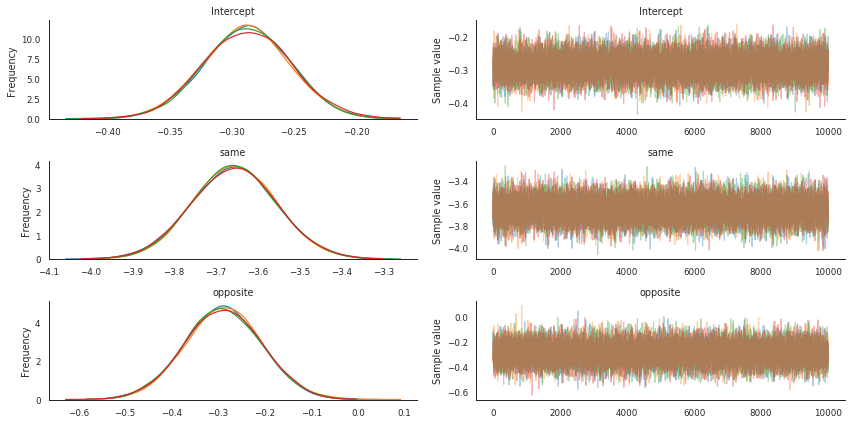

In [167]:
pm.traceplot(trace_trained, )
sns.despine();

In [168]:
df_ = bayes_model_df.loc[bayes_model_df['condition_mask'] == 'Untrained']

with pm.Model() as model: 
    intercept = pm.Normal('Intercept', 0, sd=10)
    same_coeff = pm.Normal('same', 0, sd=10)
    opposite_coeff = pm.Normal('opposite', 0, sd=10)
        
    likelihood_expression = intercept + same_coeff * df_['same'].astype(float) + opposite_coeff * df_['opposite'].astype(float)
    likelihood = pm.Bernoulli('y', 
                              pm.math.sigmoid(likelihood_expression),
                              observed=df_['errors'])

    trace_naive = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [opposite, same, Intercept]
Sampling 4 chains: 100%|██████████| 44000/44000 [03:51<00:00, 190.22draws/s]


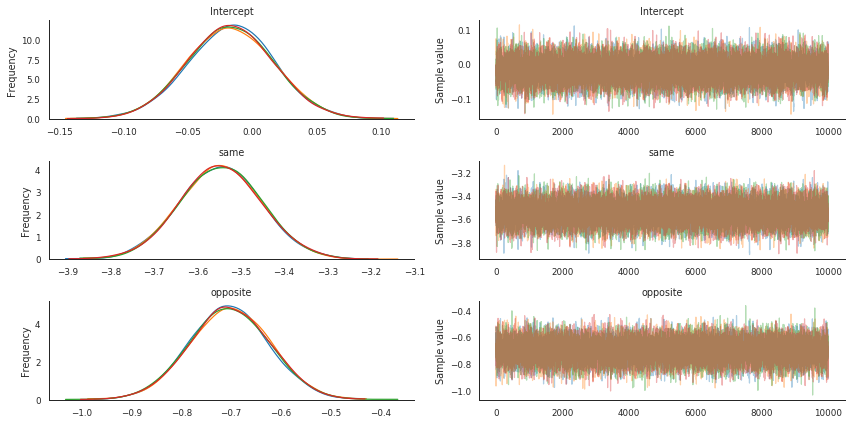

In [169]:
pm.traceplot(trace_naive, )
sns.despine();

In [170]:
def compare_vars(var_name):
    var_trained_trace = trace_trained.get_values(var_name)
    var_untrained_trace = trace_naive.get_values(var_name)
    
    probs = {'gt': [], 'lt': []}

    for theta in np.unique(var_untrained_trace):
        p_theta_1 = len(var_untrained_trace[var_untrained_trace == theta])
        p_theta_1 /= len(var_untrained_trace)

        p_theta_0 = len(var_trained_trace[var_trained_trace > theta])
        p_theta_0 /= len(var_trained_trace)

        probs['gt'].append(p_theta_1 * p_theta_0)
        
        p_theta_0 = len(var_trained_trace[var_trained_trace < theta])
        p_theta_0 /= len(var_trained_trace)
        
        probs['lt'].append(p_theta_1 * p_theta_0)

    probs = {k: np.sum(v) for k, v in probs.items()}
    
    return probs

same_probs = compare_vars('same')
opposite_probs = compare_vars('opposite')
intercept_probs = compare_vars('Intercept')

In [171]:
same_probs

{'gt': 0.20810418500000002, 'lt': 0.7918958150000001}

In [172]:
opposite_probs

{'gt': 0.9998909212500003, 'lt': 0.00010907875000000003}

In [173]:
intercept_probs

{'gt': 0.0, 'lt': 1.0000000000000004}

In [174]:
def diff_plot(var_name, ax, num_bins=100):

    var_trained_trace = trace_trained.get_values(var_name)
    var_untrained_trace = trace_naive.get_values(var_name)

    var_min = min(var_trained_trace.min(), var_untrained_trace.min())
    var_max = max(var_trained_trace.max(), var_untrained_trace.max())

    bin_size = (var_max - var_min) / num_bins
    var_range = np.arange(var_min, var_max, bin_size)

    trained_counts, trained_bins = np.histogram(var_trained_trace, var_range)#, density=True)
    naive_counts, naive_bins = np.histogram(var_untrained_trace, var_range)#, density=True)
    
    naive_dist = naive_counts / naive_counts.sum()
    trained_dist = trained_counts / trained_counts.sum()
    
    ax.plot(trained_bins[:-1], trained_dist, 
            label='Trained')

    ax.plot(naive_bins[:-1], naive_dist,
            label='Untrained')
        
    return ax

fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=150)

diff_plot('same', axes[0])
plt.setp(axes[0], xlabel='Same')

diff_plot('opposite', axes[1])
plt.setp(axes[1], xlabel='Opposite')

diff_plot('Intercept', axes[2])
plt.setp(axes[2], xlabel='Intercept')

axes[0].legend(loc=0)
    
sns.despine()

## Hierarchical Bayes

In [199]:
df_ = bayes_model_df.loc[bayes_model_df['condition_mask'] == 'Trained']
num_subjects = len(df_['subject'].unique())

with pm.Model() as model: 
    # Shared (hyper)priors for subjects within group
    intercept_mu = pm.Normal('Intercept_mu', 0, sd=20)
    same_mu = pm.Normal('same_mu', 0, sd=20)
    opposite_mu = pm.Normal('opposite_mu', 0, sd=20)
    
    intercept_sigma = pm.HalfCauchy('Intercept_sigma', 5)
    same_sigma = pm.HalfCauchy('same_sigma', 5)
    opposite_sigma = pm.HalfCauchy('opposite_sigma', 5)
    
    # Per-subject coefficient priors
    intercept = pm.Normal('Intercept', 
                          mu=intercept_mu, sd=intercept_sigma,
                          shape=num_subjects)
    
    same_coeff = pm.Normal('same', 
                           mu=same_mu, sd=same_sigma,
                           shape=num_subjects)
    
    opposite_coeff = pm.Normal('opposite', 
                               mu=opposite_mu, sd=opposite_sigma,
                               shape=num_subjects)
        
    # Likelihood - df_['subject'] indexes `intercept` (etc) RV
    likelihood_expression = intercept[df_['subject'].values.astype(int)] 
    likelihood_expression += same_coeff[df_['subject'].values.astype(int)] * df_['same'].astype(float) 
    likelihood_expression += opposite_coeff[df_['subject'].values.astype(int)] * df_['opposite'].astype(float)
    
    likelihood = pm.Bernoulli('y', 
                              pm.math.sigmoid(likelihood_expression),
                              observed=df_['errors'])

    trace_trained = pm.sample(10000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [opposite, same, Intercept, opposite_sigma, same_sigma, Intercept_sigma, opposite_mu, same_mu, Intercept_mu]
100%|██████████| 11000/11000 [10:07<00:00, 18.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


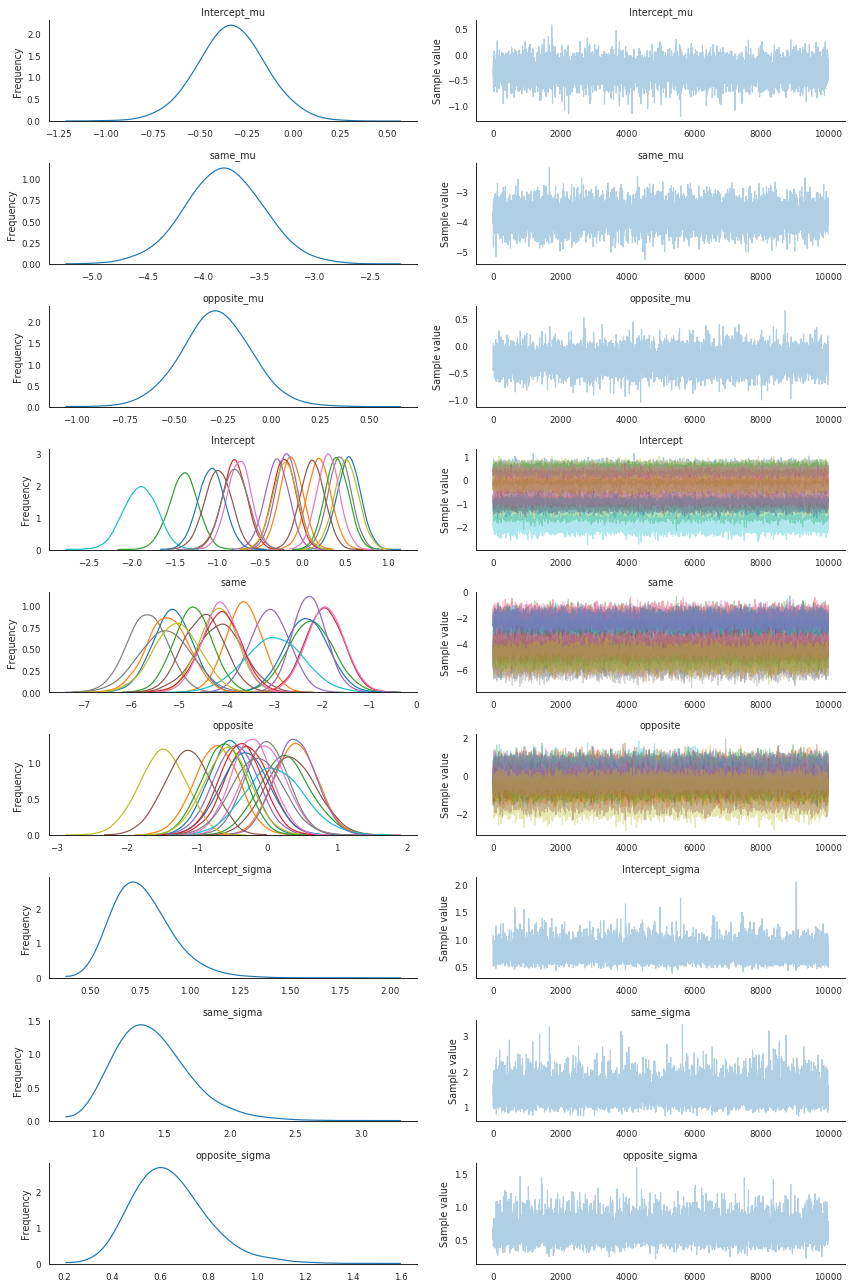

In [200]:
pm.traceplot(trace_trained, )
sns.despine();

In [201]:
df_ = bayes_model_df.loc[bayes_model_df['condition_mask'] == 'Untrained']
df_['subject'] = df_['subject'].astype(int) - 19
num_subjects = len(df_['subject'].unique())

with pm.Model() as model: 
    
    intercept_mu = pm.Normal('Intercept_mu', 0, sd=20)
    same_mu = pm.Normal('same_mu', 0, sd=20)
    opposite_mu = pm.Normal('opposite_mu', 0, sd=20)
    
    intercept_sigma = pm.HalfCauchy('Intercept_sigma', 5)
    same_sigma = pm.HalfCauchy('same_sigma', 5)
    opposite_sigma = pm.HalfCauchy('opposite_sigma', 5)
    
    intercept = pm.Normal('Intercept', 
                          mu=intercept_mu, sd=intercept_sigma,
                          shape=num_subjects)
    
    same_coeff = pm.Normal('same', 
                           mu=same_mu, sd=same_sigma,
                           shape=num_subjects)
    
    opposite_coeff = pm.Normal('opposite', 
                               mu=opposite_mu, sd=opposite_sigma,
                               shape=num_subjects)
        
    likelihood_expression = intercept[df_['subject'].values.astype(int)] 
    likelihood_expression += same_coeff[df_['subject'].values.astype(int)] * df_['same'].astype(float) 
    likelihood_expression += opposite_coeff[df_['subject'].values.astype(int)] * df_['opposite'].astype(float)
    
    likelihood = pm.Bernoulli('y', 
                              pm.math.sigmoid(likelihood_expression),
                              observed=df_['errors'])

    trace_naive = pm.sample(10000, tune=1000, chains=1)

/home/gianni/Environments/vidrovr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [opposite, same, Intercept, opposite_sigma, same_sigma, Intercept_sigma, opposite_mu, same_mu, Intercept_mu]
100%|██████████| 11000/11000 [10:04<00:00, 20.12it/s]
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


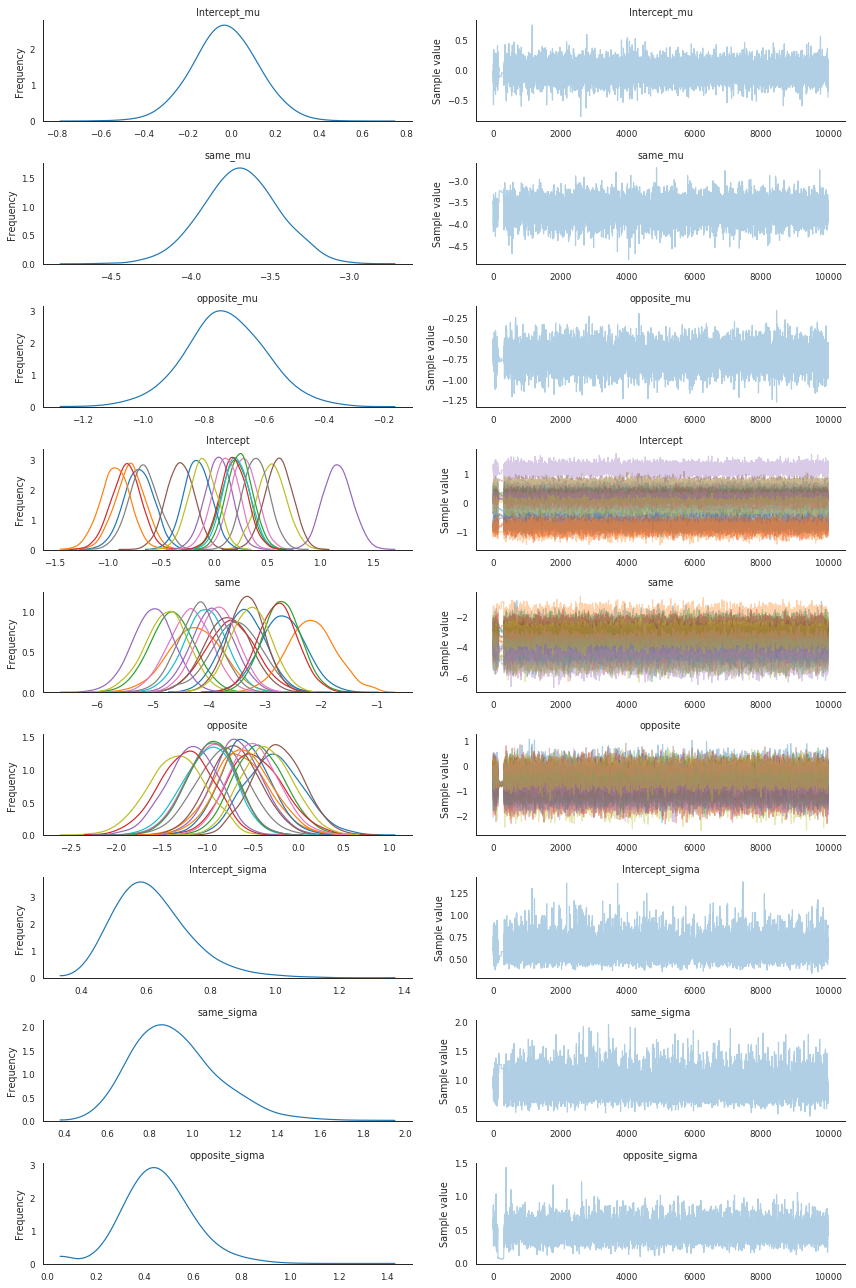

In [207]:
pm.traceplot(trace_naive)
sns.despine();

In [203]:
same_probs = compare_vars('same_mu')
opposite_probs = compare_vars('opposite_mu')
intercept_probs = compare_vars('Intercept_mu')

In [204]:
same_probs

{'gt': 0.38000996, 'lt': 0.61999004}

In [205]:
opposite_probs

{'gt': 0.97779996, 'lt': 0.02220004}

In [206]:
intercept_probs

{'gt': 0.09637155000000001, 'lt': 0.90362845}

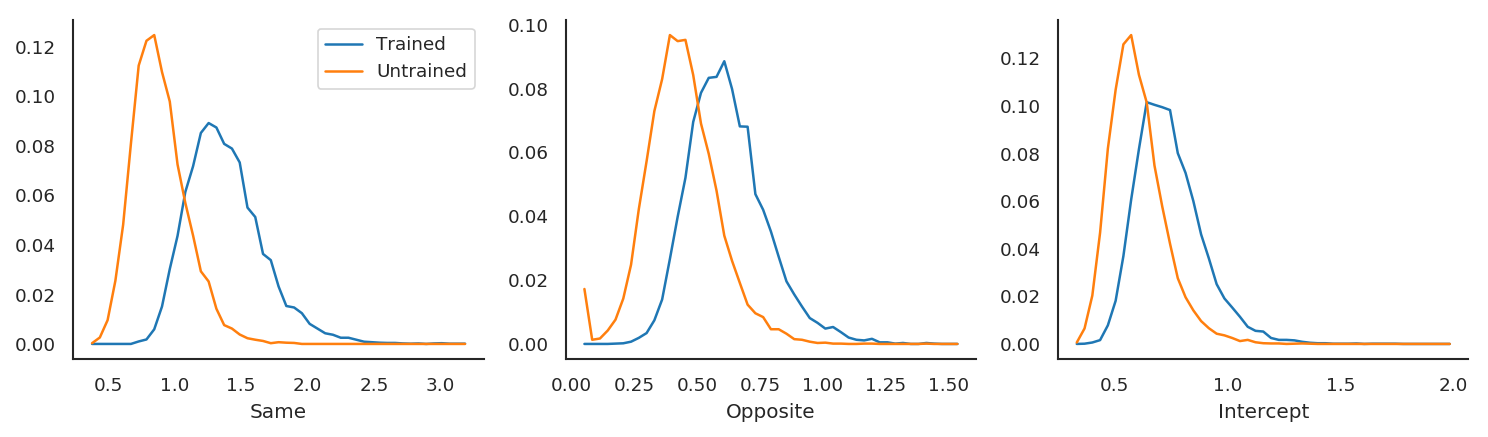

In [210]:
def diff_plot(var_name, ax, num_bins=50):

    var_trained_trace = trace_trained.get_values(var_name)
    var_untrained_trace = trace_naive.get_values(var_name)

    var_min = min(var_trained_trace.min(), var_untrained_trace.min())
    var_max = max(var_trained_trace.max(), var_untrained_trace.max())

    bin_size = (var_max - var_min) / num_bins
    var_range = np.arange(var_min, var_max, bin_size)

    trained_counts, trained_bins = np.histogram(var_trained_trace, var_range)#, density=True)
    naive_counts, naive_bins = np.histogram(var_untrained_trace, var_range)#, density=True)
    
    naive_dist = naive_counts / naive_counts.sum()
    trained_dist = trained_counts / trained_counts.sum()
    
    ax.plot(trained_bins[:-1], trained_dist, 
            label='Trained')

    ax.plot(naive_bins[:-1], naive_dist,
            label='Untrained')
        
    return ax

fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=150)

diff_plot('same_sigma', axes[0])
plt.setp(axes[0], xlabel='Same')

diff_plot('opposite_sigma', axes[1])
plt.setp(axes[1], xlabel='Opposite')

diff_plot('Intercept_sigma', axes[2])
plt.setp(axes[2], xlabel='Intercept')

axes[0].legend(loc=0)
    
sns.despine()

In [194]:
trace_trained.get_values('Intercept_mu')

array([-0.40930476, -0.12674366, -0.24854612, ..., -0.24980911,
       -0.70224386, -0.15203566])

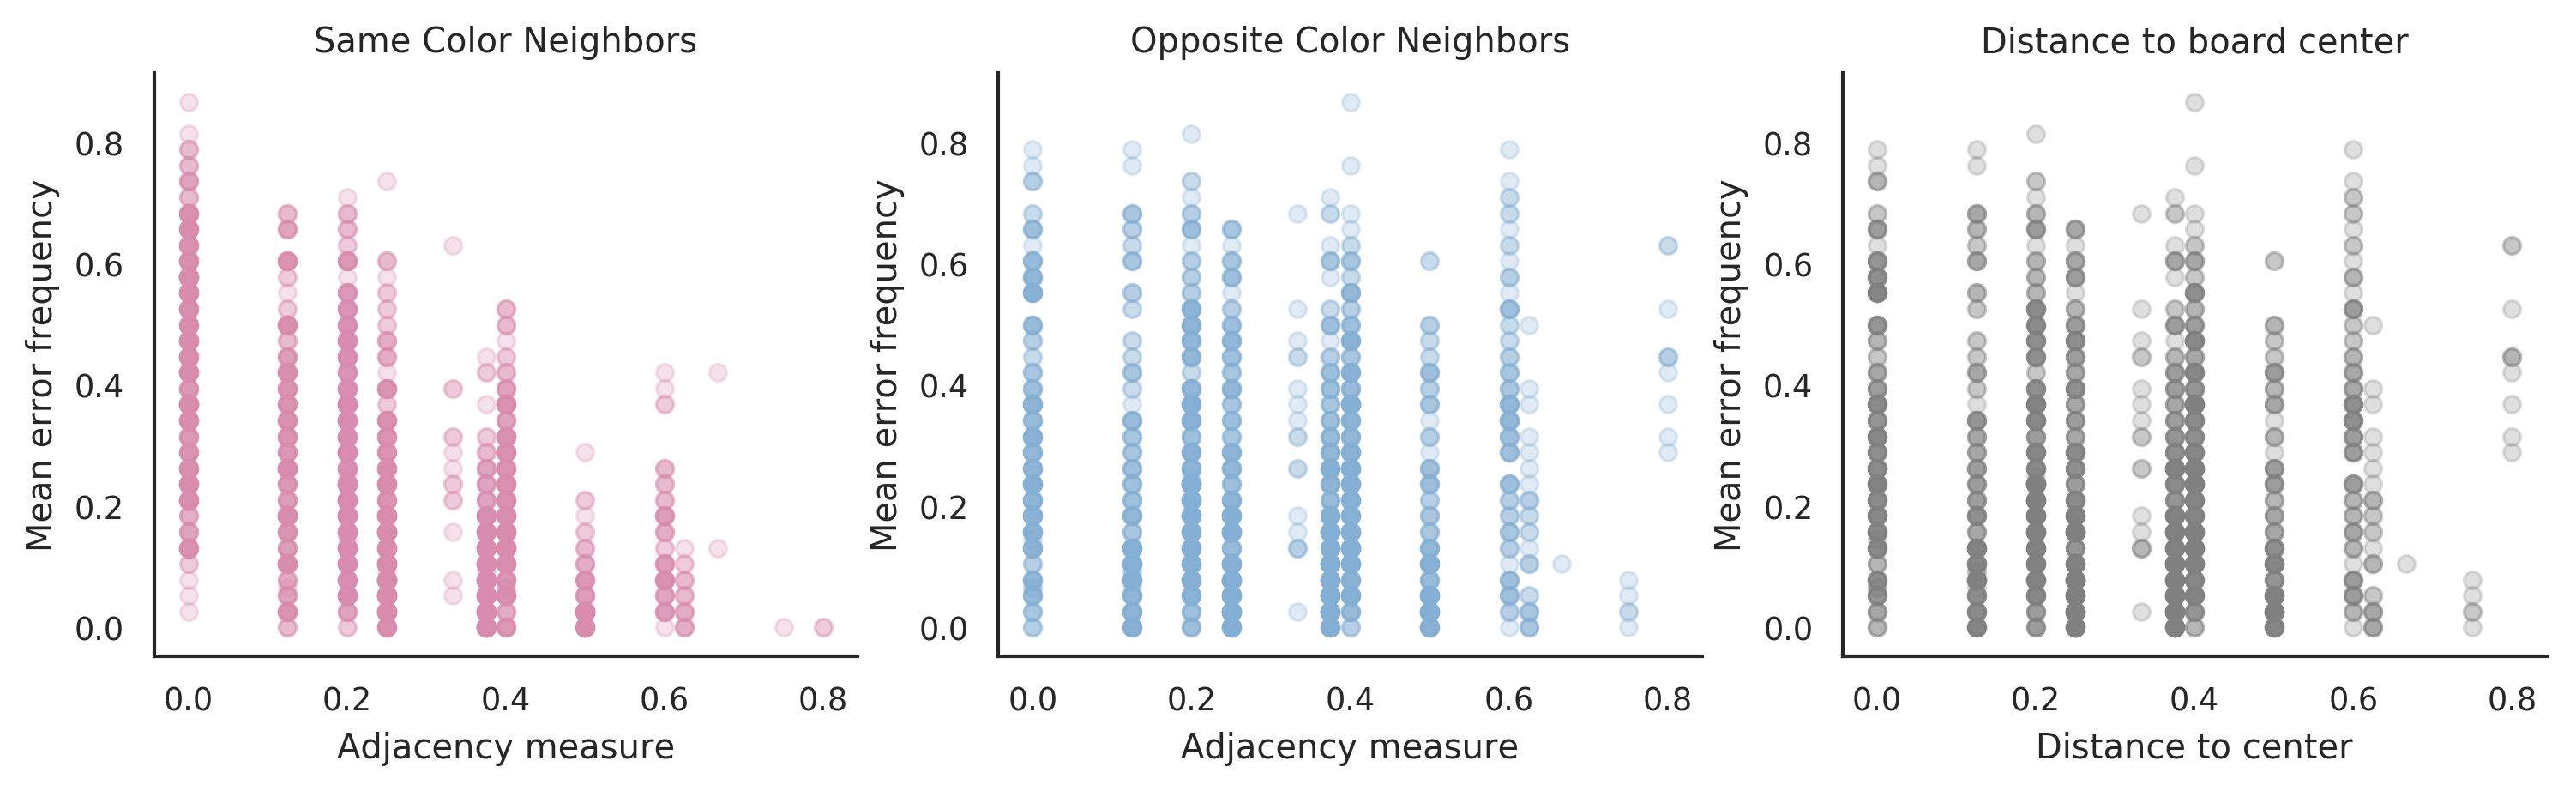

In [90]:
num_rows = 1
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, 
                         figsize=(num_cols * 4, num_rows * 3), 
                         dpi=300)

ax = axes[0]
ax.scatter(x_same, y, alpha=.25, color=colors[0])
plt.setp(ax, title='Same Color Neighbors', xlabel='Adjacency measure')

# x_support = np.arange(0, 1, .1)
# predicted = model.predict(result.params, x_support[:, np.newaxis])

# axes.plot(x_support, predicted, color=colors[1], linewidth=2, zorder=-1)

ax = axes[1]
ax.scatter(x_opposite, y, alpha=.25, color=colors[2])
plt.setp(ax, title='Opposite Color Neighbors', xlabel='Adjacency measure')

ax = axes[2]
ax.scatter(x_opposite, y, alpha=.25, color='grey')
plt.setp(ax, title='Distance to board center', xlabel='Distance to center')

plt.setp(axes, ylabel='Mean error frequency')
sns.despine()

# Deprecated

In [11]:
# This appears to be for game feature analyses, not neighborhoods
# don't touch it for now

# for f in ['1111', '1110', '1101', '1100', '1010', '1001']:
#     sum_df['filtered_{}b'.format(f)] = sum_df.apply(lambda row: filter_by_occupied(row, '{}b'.format(f)), axis=1)
#     sum_df['filtered_{}w'.format(f)] = sum_df.apply(lambda row: filter_by_occupied(row, '{}w'.format(f)), axis=1)

# feature_list = ['1111', '1110', '1101', '1100', '1010', '1001']
# x = []
# for f in feature_list:
#     xb = [loc_val for board in sum_df['filtered_{}b'.format(f)] for loc_val in board]
#     xw = [loc_val for board in sum_df['filtered_{}w'.format(f)] for loc_val in board]
#     x_ = np.stack(xb) + np.stack(xw)
    
#     x.append(x_)

In [ ]:
tidy_adjacencies = tidy.apply(
    lambda x: get_adjacency(x, bp_name='Black Position (final)', wp_name='White Position (final)'),
    axis=1
)

In [ ]:
board_set = pd.concat([board_set, adjacencies], axis=1)

In [ ]:
tidy['Cond. Total Adj (final)'] = tidy_adjacencies['Cond. Total']
tidy['Total Adj (final)'] = tidy_adjacencies['Total']

tidy['Cond. Total Adj'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Cond. Total'])
tidy['Total Adj'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Total'])

In [ ]:
tidy['Errors by loc'] = errors_by_location

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)

for i, col in enumerate(['Total', 'Cond. Total', 'Same', 'Opposite']):
    ax = axes.flatten()[i]
    y0 = board_set.loc[board_set['Is Real'], col].values
    y1 = board_set.loc[~board_set['Is Real'], col].values

    ax.hist(y0, bins=np.arange(0, 1, .05), alpha=.5, label='Real', color=colors[0])
    ax.hist(y1, bins=np.arange(0, 1, .05), alpha=.5, label='Fake', color=colors[1])
    
    plt.setp(ax, title=col)
    
    ttest_result = sts.ttest_ind(y0, y1)
    
    print(
        col, 'T-Test: {:.3f}, {:.2f}, {:.5f}'.format((y0.mean() - y1.mean()), ttest_result.statistic, ttest_result.pvalue)
    )

axes[0, 0].legend(loc=0)

plt.setp(
    axes, 
    xlabel='Fraction Occupied Neighbors',
    ylim=[0, 25]
)

sns.despine()

#### Test these bubbies for multicollinearity

In [ ]:
tidy.head()

In [ ]:
board_set['Num Pieces'] = board_set.apply(
    lambda row: np.sum(np.stack([int(i) for i in row['Black Position']]) + np.stack([int(i) for i in row['White Position']])),
    axis=1
)

In [ ]:
x = board_set['Num Pieces']
y1 = board_set['Total']
y2 = board_set['Cond. Total']

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
print(sts.linregress(x, y1))
# print(sts.linregress(x, y2))

axes[0].scatter(x, y1, alpha=.5)

r = board_set['Is Real'] == True
x_real = board_set.loc[r, 'Num Pieces']
y2_real = board_set.loc[r, 'Cond. Total']
axes[1].plot(x_real, y2_real, alpha=.5, linestyle='none', marker='o')
print(sts.linregress(x_real, y2_real))

x_fake = board_set.loc[~r, 'Num Pieces']
y2_fake = board_set.loc[~r, 'Cond. Total']
axes[1].plot(x_fake, y2_fake, alpha=.5, linestyle='none', marker='o')
print(sts.linregress(x_fake, y2_fake))


plt.setp(
    axes,
    xlabel='Num Pieces',
    ylim=[-1, 1], ylabel='Mean Fraction Occupied'
)

plt.setp(axes[0], title='Total Adjacency')
plt.setp(axes[1], title='Conditional Adjacency')
sns.despine()

Woof.

In [ ]:
total_adj_means = board_set.pivot_table(index='Num Pieces', values='Total')
cond_adj_means = board_set.pivot_table(index='Num Pieces', values='Total')

In [ ]:
board_set['Adjusted Total'] = board_set.apply(
    lambda row: row['Total'] - total_adj_means.loc[row['Num Pieces']],
    axis=1
)

board_set['Adjusted Cond.'] = board_set.apply(
    lambda row: row['Cond. Total'] - total_adj_means.loc[row['Num Pieces']],
    axis=1
)

tidy['Adjusted Total'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Adjusted Total'])
tidy['Adjusted Cond.'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Adjusted Cond.'])

In [ ]:
tidy['num_pieces'] = tidy['Num Pieces'] / 36
tidy['neighborhood_size'] = tidy['Cond. Total Adj']
tidy['y'] = tidy['Total Errors']


NBFam = sm.families.NegativeBinomial()

formula1 = 'y ~ num_pieces + neighborhood_size'
formula2 = 'y ~ num_pieces'
formula3 = 'y ~ neighborhood_size'
formula4 = 'y ~ C(num_pieces) + neighborhood_size'

def get_nbr_params(formula, condition='Trained', is_real=True):
    models = []
    c = tidy['Condition'] == condition
    r = tidy['Is Real'] == is_real
    
    T = tidy.loc[c & r]
    
    for subject_id in T['Subject ID'].unique():
        p = T['Subject ID'] == subject_id
        S = T.loc[p]
        
        model = smf.glm(formula=formula, data=S, family=NBFam)
        model = model.fit(method='bfgs', maxiter=10000)
        models.append(model)
        
    params = pd.DataFrame([m.params for m in models], index=T['Subject ID'].unique())
    pvals = pd.DataFrame([m.pvalues for m in models], index=T['Subject ID'].unique())
    lls = pd.DataFrame([{'ll': m.llf} for m in models], index=T['Subject ID'].unique())
    
    for df in [params, pvals, lls]:
        df['Condition'] = condition
        df['Is Real'] = is_real

    return params, pvals, lls, models


def get_nbr_partial_corr(condition='Trained', is_real=True):
    models1 = []
    models2 = []
    corrs = []
    c = tidy['Condition'] == condition
    r = tidy['Is Real'] == is_real
        
    for subject_id in tidy.loc[c, 'Subject ID'].unique():
        p = tidy['Subject ID'] == subject_id
        
        f1 = 'y ~ num_pieces'
        m1 = smf.glm(formula=f1, data=tidy.loc[r&p], family=NBFam)
        m1 = m1.fit(method='bfgs', maxiter=10000)
        
        tidy.loc[c&r&p, 'res1'] = m1.resid_response
        
        f2 = 'neighborhood_size ~ num_pieces'
        m2 = smf.glm(f2, data=tidy.loc[r&p], family=sm.families.Gaussian())
        m2 = m2.fit(maxiter=10000)
        
        tidy.loc[c&r&p, 'res2'] = m2.resid_response
        
        models1.append(m1)
        models2.append(m2)
        
        corr = sts.spearmanr(m1.resid_response, m2.resid_response)
        corrs.append(corr)
        
    params = pd.DataFrame([m.params for m in models], index=tidy.loc[c, 'Subject ID'].unique())
    pvals = pd.DataFrame([m.pvalues for m in models], index=tidy.loc[c, 'Subject ID'].unique())
    lls = pd.DataFrame([{'ll': m.llf} for m in models], index=tidy.loc[c, 'Subject ID'].unique())
    corrs = pd.DataFrame(
        [{'corr': corr, 'pval': pval} for corr, pval in corrs], 
        index=tidy.loc[c, 'Subject ID'].unique()
    )
    
    for df in [params, pvals, lls, corrs]:
        df['Condition'] = condition
        df['Is Real'] = is_real

    return corrs

In [ ]:
corr_list = []
for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        corrs = get_nbr_partial_corr(condition=condition, is_real=is_real)
        corr_list.append(corrs)
        
corr_df = pd.concat(corr_list)

In [ ]:
corr_df.pivot_table(
    index='Condition', columns='Is Real', values='pval', aggfunc=np.mean
)

In [ ]:
param_dfs = []
pvals_dfs = []
lls_dfs = []
models_list = []

for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        param_df, pvals_df, lls_df, models = get_nbr_params(formula1, condition=condition, is_real=is_real)

        param_dfs.append(param_df)
        pvals_dfs.append(pvals_df)
        lls_dfs.append(lls_df)
        models_list.append(models)
        
params = pd.concat(param_dfs)
pvals = pd.concat(pvals_dfs)
lls1 = pd.concat(lls_dfs)

In [ ]:
param_dfs = []
pvals_dfs = []
lls_dfs = []
models_list = []

for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        param_df, pvals_df, lls_df, models = get_nbr_params(formula3, condition=condition, is_real=is_real)
        param_dfs.append(param_df)
        pvals_dfs.append(pvals_df)
        lls_dfs.append(lls_df)
        models_list.append(models)
        
params = pd.concat(param_dfs)
pvals = pd.concat(pvals_dfs)
lls2 = pd.concat(lls_dfs)

In [ ]:
bics1 = [m.bic for ms in models_list for m in ms]
lls1 = [m.llf for ms in models_list for m in ms]

In [ ]:
bics2 = [m.bic for ms in models_list for m in ms]
lls2 = [m.llf for ms in models_list for m in ms]

In [ ]:
f_idx = lls1['Condition'] == 'Trained'
f_col = lls1['Is Real'] == True

sts.chisquare(2 * lls1['ll'] - lls2['ll'], ddof=1)

In [ ]:
print(np.mean(bics1), np.mean(bics2))#, np.mean(bics3))

In [ ]:
sts.chisquare(2 * (np.stack(lls1) - np.stack(lls2)), ddof=1)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

f_idx_pvals = pvals['Condition'] == 'Trained'
f_col_pvals = pvals['Is Real'] == True

ax = axes[0]

p = pvals.loc[f_idx_pvals & f_col_pvals]
s = p['neighborhood_size']
n = p['num_pieces']

ax.scatter(s, n, color=colors[0], alpha=.8, label='Real')
# ax.hist(s, bins=np.arange(0, 1, .05), color=colors[5], alpha=.5)
# ax = axes[0, 1]

p = pvals.loc[f_idx_pvals & ~f_col_pvals]
s = p['neighborhood_size']
n = p['num_pieces']

ax.scatter(s, n, color=colors[1], alpha=.8, label='Fake')

ax.legend(loc=0)


ax = axes[1]

p = pvals.loc[~f_idx_pvals & f_col_pvals]
s = p['neighborhood_size']
n = p['num_pieces']

ax.scatter(s, n, color=colors[2], alpha=.8, label='Real')
# ax.hist(s, bins=np.arange(0, 1, .05), color=colors[5], alpha=.5)
# ax = axes[0, 1]

p = pvals.loc[~f_idx_pvals & ~f_col_pvals]
s = p['neighborhood_size']
n = p['num_pieces']

ax.scatter(s, n, color=colors[3], alpha=.8, label='Fake')

ax.legend(loc=0)

plt.setp(
    axes, 
    xlim=[-.05, 1.05], ylim=[-.05, 1.05],
    xlabel='Neighborhood Size',
    ylabel='Num Pieces'
)


plt.setp(axes[0], title='Trained')
plt.setp(axes[1], title='Untrained')

sns.despine()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

c = tidy['Condition'] == 'Trained'
r = tidy['Is Real'] == True

ax = axes[0]
x = tidy.loc[c & r, 'res1']
y = tidy.loc[c & r, 'res2']
ax.scatter(x, y, color=colors[0], alpha=.5, label='Real')

x = tidy.loc[c & ~r, 'res1']
y = tidy.loc[c & ~r, 'res2']
ax.scatter(x, y, color=colors[1], alpha=.5, label='Fake')

ax.legend(loc=0)
plt.setp(ax, title='Trained residuals')

ax = axes[1]
x = tidy.loc[~c & r, 'res1']
y = tidy.loc[~c & r, 'res2']
ax.scatter(x, y, color=colors[2], alpha=.5, label='Real')

x = tidy.loc[~c & ~r, 'res1']
y = tidy.loc[~c & ~r, 'res2']
ax.scatter(x, y, color=colors[3], alpha=.5, label='Fake')
ax.legend(loc=0)

plt.setp(ax, title='Untrained residuals')

plt.setp(
    axes,
    xlabel='errors ~ num_pieces',
    ylabel='nbrh_size ~ num_pieces'
)

sns.despine()

In [ ]:
nbs_mean_pvals = corr_df.pivot_table(
    index='Condition', columns='Is Real', values='pval', 
    aggfunc=np.mean
)

nbs_mean_pvals.columns.name = 'PVALS NGHBRS'
nbs_mean_pvals.index.name = ''
nbs_mean_pvals

In [ ]:
nbs_mean_pvals = pvals.pivot_table(
    index='Condition', columns='Is Real', values='neighborhood_size', 
    aggfunc=np.mean
)

nbs_mean_pvals.columns.name = 'PVALS NGHBRS'
nbs_mean_pvals.index.name = ''
nbs_mean_pvals

In [ ]:
nps_mean_pvals = pvals.pivot_table(
    index='Condition', columns='Is Real', values='num_pieces', 
    aggfunc=np.mean
)

nps_mean_pvals.columns.name = 'PVALS NPCS'
nps_mean_pvals.index.name = ''
nps_mean_pvals

## Position difficulty

In [ ]:
difficulties = tidy.pivot_table(
    index='Position ID', columns='Condition', values='Total Errors',
    aggfunc=np.mean
)

# These are total errors, so more is WORSE
neighborhood_type = 'Cond. Total Adj'

In [ ]:
difficulties['Is Real'] = difficulties.index.map(
    lambda x: tidy.loc[tidy['Position ID'] == x, 'Is Real'].values[0]
)

difficulties['neighborhood_size'] = difficulties.index.map(
    lambda x: tidy.loc[tidy['Position ID'] == x, neighborhood_type].values[0]
)

In [ ]:
difficulties.head()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

f_col = difficulties['Is Real'] == True

ax = axes[0]

d = difficulties.loc[f_col]
ax.scatter(d['neighborhood_size'], d['Trained'] / 36, color=colors[0], label='Real', alpha=.8)

d = difficulties.loc[~f_col]
ax.scatter(d['neighborhood_size'], d['Trained'] / 36, color=colors[1], label='Fake', alpha=.8)

ax.legend(loc=0)
plt.setp(ax, title='Trained')

ax = axes[1]

d = difficulties.loc[f_col]
ax.scatter(d['neighborhood_size'], d['Untrained'] / 36, color=colors[2], label='Real', alpha=.8)

d = difficulties.loc[~f_col]
ax.scatter(d['neighborhood_size'], d['Untrained'] / 36, color=colors[3], label='Fake', alpha=.8)

ax.legend(loc=0)
plt.setp(ax, title='Untrained')

plt.setp(
    axes,
    xlim=[0, 1], xlabel='Neighborhood Size',
    ylim=[0, 1], ylabel='Error Probability'
)


sns.despine()

In [ ]:
sts.linregress(difficulties.loc[f_col, 'neighborhood_size'], difficulties.loc[f_col, 'Untrained']/36)

### Locations

In [ ]:
def get_error_by_adjacency_per_loc(row):
    position_id = row.name
    mean_error_by_loc = np.stack(tidy.loc[tidy['Position ID'] == position_id, 'Errors by loc'].values).mean(axis=0)
    
    return mean_error_by_loc


adj_frame = pd.DataFrame(adjacencies_by_location, columns=['Adjacency by loc'])
adj_frame['Mean errors by loc'] = adj_frame.apply(get_error_by_adjacency_per_loc, axis=1)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=300)

x = np.stack(adj_frame['Adjacency by loc']).flatten()
y = np.stack(adj_frame['Mean errors by loc']).flatten()

axes.scatter(x, y)
sns.despine()

In [ ]:
np.stack(tidy['Errors by loc'].iloc[:10].values).mean(axis=0).shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

ax = axes[0]
f_col = difficulties['Is Real'] == True

ax.hist(difficulties.loc[f_col, 'Trained'], color=colors[0], bins=np.arange(0, 36, 1), alpha=.5, label='Real')
ax.hist(difficulties.loc[~f_col, 'Trained'], color=colors[1], bins=np.arange(0, 36, 1), alpha=.5, label='Fake')

ax = axes[1]

ax.hist(difficulties.loc[f_col, 'Untrained'], color=colors[2], bins=np.arange(0, 36, 1), alpha=.5, label='Real')
ax.hist(difficulties.loc[~f_col, 'Untrained'], color=colors[3], bins=np.arange(0, 36, 1), alpha=.5, label='Fake')

sns.despine()

In [ ]:
m = models_list[0][0]

In [ ]:
m.pvalues

In [ ]:
idx_names = ['Trained', 'Untrained']
col_names = [False, True]

results = pd.DataFrame(index=idx_names, columns=col_names)

In [ ]:
for idx in idx_names:
    for col in col_names:
        f_idx = tidy['Condition'] == idx
        f_col = tidy['Is Real'] == col
        t = tidy.loc[f_idx & f_col]
        
        formula = 'e ~ num_pieces + '

In [ ]:
y0.mean()

In [ ]:
y1.mean()

In [ ]:
sts.ttest_ind(y0, y1)

In [ ]:
#     x0 = tidy.loc[c_filter & s_filter, adj_type].values
#     x1 = tidy.loc[~c_filter & s_filter, adj_type].values

#     y0 = tidy.loc[c_filter & s_filter, adj_type + ' (final)'].values
#     y1 = tidy.loc[~c_filter & s_filter, adj_type + ' (final)'].values

In [ ]:
c_filter = tidy['Condition'] == 'Trained'


def all_subject_regress(adj_type):

    regressions = {}

    for subject in tidy['Subject ID'].unique():
        s_filter = tidy['Subject ID'] == subject


        x = tidy.loc[s_filter, adj_type].values
        y = tidy.loc[s_filter, adj_type + ' (final)'].values

        regressions[subject] = sts.linregress(x, y)
        
    regression_result = pd.DataFrame.from_dict(
        {k: {'slope': v.slope, 'intercept': v.intercept} for k, v in regressions.items()}, 
        orient='index'
    )
    
    regression_result['Condition'] = regression_result.index.map(
        lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0]
    )
    
    return regression_result

In [ ]:
def all_subject_regression_histogram(regression_result, ax, value='slope'):
    r_s_filter = regression_result['Condition'] == 'Trained'

    h0 = regression_result.loc[r_s_filter, value].values
    h1 = regression_result.loc[~r_s_filter, value].values
    
    ax.hist(h0, bins=np.arange(0, 1, .05), alpha=.5, label='Trained')
    ax.hist(h1, bins=np.arange(0, 1, .05), alpha=.5, label='Untrained')
    
    return (h0.mean() - h1.mean()), sts.ttest_ind(h0, h1)



In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
regression_result = all_subject_regress('Total Adj')
dif, res = all_subject_regression_histogram(regression_result, axes[0])

print(dif, res)
plt.setp(axes[0], title='Total Adj')
axes[0].legend(loc=0)

regression_result = all_subject_regress('Cond. Total Adj')
dif, res = all_subject_regression_histogram(regression_result, axes[1])
print(dif, res)
plt.setp(axes[1], title='Cond. Total Adj')

plt.setp(axes, xlabel='Regression Coefficient')
sns.despine()

In [ ]:
p = tidy.pivot_table(
    index='Subject ID', values=['Cond. Total Adj (final)', 'Cond. Total Adj', 'Total Adj (final)', 'Total Adj'],
    aggfunc=np.mean
)

In [ ]:
p['Condition'] = p.index.map(
    lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0]
)

In [ ]:
p

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

condition_filter = p['Condition'] == 'Trained'



x = p.loc[condition_filter, 'Total Adj']
y0 = p.loc[condition_filter, 'Total Adj (final)']
y1 = p.loc[~condition_filter, 'Total Adj (final)']

axes.scatter(np.zeros_like(y0), y0)
axes.scatter(np.ones_like(y1), y1)
sns.despine()

In [ ]:
fig, axes_ = plt.subplots(1, 2, figsize=(8, 3), dpi=150)


p_ = tidy
condition_filter = p_['Condition'] == 'Trained'


axes = axes_[1]
x0 = p_.loc[condition_filter, 'Cond. Total Adj']
x1 = p_.loc[~condition_filter, 'Cond. Total Adj']

y0 = p_.loc[condition_filter, 'Cond. Total Adj (final)']
y1 = p_.loc[~condition_filter, 'Cond. Total Adj (final)']

m0 = sts.linregress(x0, y0)
m1 = sts.linregress(x1, y1)

axes.scatter(x0, y0, alpha=.2)
axes.scatter(x1, y1, alpha=.2)

axes.plot(np.arange(0, 1.1, .1), m0.slope * np.arange(0, 1.1, .1) + m0.intercept)
axes.plot(np.arange(0, 1.1, .1), m1.slope * np.arange(0, 1.1, .1) + m1.intercept)

axes.plot([0, 1], [0, 1], color='grey', linestyle='--')


axes = axes_[0]

x0 = p_.loc[condition_filter, 'Total Adj']
x1 = p_.loc[~condition_filter, 'Total Adj']

y0 = p_.loc[condition_filter, 'Total Adj (final)']
y1 = p_.loc[~condition_filter, 'Total Adj (final)']

m0 = sts.linregress(x0, y0)
m1 = sts.linregress(x1, y1)

axes.scatter(x0, y0, alpha=.2)
axes.scatter(x1, y1, alpha=.2)

axes.plot(np.arange(0, 1.1, .1), m0.slope * np.arange(0, 1.1, .1) + m0.intercept)
axes.plot(np.arange(0, 1.1, .1), m1.slope * np.arange(0, 1.1, .1) + m1.intercept)

axes.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.setp(
    axes_, 
    xlim=[0, 1], ylim=[0, 1],
    xlabel='Original Adjacency', ylabel='Reconstructed Adjacency'
)

plt.setp(axes_[1], title='Conditional')
plt.setp(axes_[0], title='Total')


sns.despine()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

axes.scatter(x0, y0)
axes.scatter(x1, y1)

sns.despine()

In [ ]:
sts.linregress(x0, y0)

In [ ]:
sts.linregress(x1, y1)